In [1]:
import torch
import MDAnalysis as mda
from torch_geometric.data import Data, InMemoryDataset
import numpy as np
import os
import os.path as osp
import warnings
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D # For 3D plotting

#from full_VGAE_egnn_clean import *

from torch.utils.data import random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import pandas as pd
import torch_geometric.transforms as T
from torch_geometric.nn.pool import global_mean_pool
import math

from torch.utils.tensorboard import SummaryWriter
import itertools
from sklearn.preprocessing import StandardScaler


from tqdm import tqdm


/home/clod/anaconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append("LIBS")
from LIBS.utils import *
from LIBS.FGVAE import *

dataset = get_dataset(initial_alignment=False)

train_loader, val_loader, test_loader = get_dataloaders(dataset)


Loading dataset ...

No root directory provided, using default path ...
Successfully loaded processed data from /home/clod/Desktop/THESIS_2/FULL_ATOM/DATA/processed/data_MD_protein.pt

Scaling positions... Max absolute position values for scaling: tensor([28.9800, 29.0000, 29.0100])
Positions shape: torch.Size([20032, 52, 3])
Including atom features: performing one hot encoding ...
Scaling features ...
not aligning the frames ...
Dataset created with 20032 graphs.
Number of graphs in the dataset: 20032
Number of features in the dataset: 6
Number of edges in the dataset: 102
Number of nodes in the dataset: 52
Number of features in the dataset: torch.Size([52, 6])



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate the mean reference structure for hybrid displacement
print("Calculating mean reference structure for the hybrid model...")
all_pos = torch.stack([data.pos for data in dataset], dim=0)  # Shape: (num_graphs, num_atoms, 3)
pos_ref_single = all_pos.mean(dim=0).to(device)  # Shape: (num_atoms, 3)

# Pre-calculate pos_ref for the test batch size
test_batch_size = test_loader.batch_size or 1  # Get actual batch size
pos_ref = pos_ref_single.repeat(test_batch_size, 1)  # Shape: (batch_size * num_atoms, 3)

pos_ref = pos_ref.to(device)  # Move to device

# Load the models 
EPOCHS = 60
lrs= ["0.0001", "0.00001"]
n_layers = [3, 5, 7, 9]
kl_mins = [0.001, 0.0001]
latent_dims = [32,64, 128]

ARCHITECTURE = 'hybrid_displacement'
FOLDER_NAME = 'test'
ENCODER_POS_PROJECTION_DIM = 64


ENCODER_TYPE = 'standard'
HIDDEN_ENCODER_CHANNELS = 256
OUT_ENCODER_CHANNELS = 128 
#NUM_ENC_LAYERS = 5
ATTENTION_ENCODER = True
LATENT_DIM = 128
TANH_ENCODER = False
NORMALIZE_ENCODER = False

# decoder
MLP_DECODER_POS_SIZE = [256,128,128]
HIDDEN_DECODER_CHANNELS = 256
#NUM_DEC_LAYERS = 5
ATTENTION_DECODER = True
TANH_DECODER = False
NORMALIZE_DECODER =  False

losses = {}
pos_pred_dict = {}
mean_dict = {}
log_var_dict = {}

for lr in lrs:
    for n_layer in n_layers:
        for kl_min in kl_mins:
            for latent_dim in latent_dims:
                # Define the model
                print(f"Initializing model with lr={lr}, n_layers={n_layer}, kl_min={kl_min}, latent_dim={latent_dim}")
                
                # Initialize the model
                model = FGVAE(encoder=EGNN_Encoder(
                    in_channels=dataset[0].num_features,
                    architecture=ARCHITECTURE,
                    pos_projection_dim=ENCODER_POS_PROJECTION_DIM,
                    hidden_channels_egnn=HIDDEN_ENCODER_CHANNELS,
                    out_channels_egnn=OUT_ENCODER_CHANNELS,
                    num_egnn_layers=n_layer,
                    attention=ATTENTION_ENCODER,
                    tanh=TANH_ENCODER,
                    normalize=NORMALIZE_ENCODER,
                    latent_dim=latent_dim
                ),
                decoder=EGNN_Decoder(
                    latent_dim=latent_dim,
                    architecture=ARCHITECTURE,
                    node_feature_dim_initial=dataset[0].num_features,
                    hidden_nf=HIDDEN_DECODER_CHANNELS,
                    num_egnn_layers=n_layer,
                    attention=ATTENTION_DECODER,
                tanh=TANH_DECODER,
                normalize=NORMALIZE_DECODER,
                pos_MLP_size=MLP_DECODER_POS_SIZE
                
                ))

                try:
                    path_model = f'../JIMI_RUNS/{ARCHITECTURE}/{FOLDER_NAME}/sim_lr_{lr}_layers_{n_layer}_kl_min_{kl_min}_latent_dim_{latent_dim}/model_epoch_{EPOCHS}.pth'
                    print(f'Loading model from {path_model}')
                    model.load_state_dict(torch.load(path_model))

                    model.eval()
                    model = model.to(device)
                    #print(f'Loaded model with lr={lr}, n_layers={n_layer}, kl_min={kl_min}, latent_dim={latent_dim}')

                    pos_pred_dict[(lr, n_layer, kl_min, latent_dim)] = []
                    mean_dict[(lr, n_layer, kl_min, latent_dim)] = []
                    log_var_dict[(lr, n_layer, kl_min, latent_dim)] = []

                        # Evaluate the model on the test set
                    test_loss = 0.0
                    with torch.no_grad():
                        for data in test_loader:
                            data = data.to(device)
                            
                            pos_pred, mean, log_var, batch_vec = model(data, pos_ref=pos_ref)
                            loss = reconstruction_loss(pos_pred, data.pos, data.batch)
                            test_loss += loss.item()
                            pos_pred_dict[(lr, n_layer, kl_min, latent_dim)].append(pos_pred)
                            mean_dict[(lr, n_layer, kl_min, latent_dim)].append(mean)
                            log_var_dict[(lr, n_layer, kl_min, latent_dim)].append(log_var)

                    print(f'Test Loss for lr={lr}, n_layers={n_layer}, kl_min={kl_min}, latent_dim={latent_dim}: {test_loss / len(test_loader)}')

                    losses[(lr, n_layer, kl_min, latent_dim)] = test_loss / len(test_loader)

                except:           
                    print(f"Failed to load model with lr={lr}, n_layers={n_layer}, kl_min={kl_min}, latent_dim={latent_dim} - skipping")
                    continue

                #     print(f"Failed to load model with lr={lr}, n_layers={n_layer}, kl_min={kl_min}, latent_dim={latent_dim} - skipping")
                #     continue
#sim_lr_0.0001_layers_5_kl_min_0.0001_latent_dim_64


Calculating mean reference structure for the hybrid model...
Initializing model with lr=0.0001, n_layers=3, kl_min=0.001, latent_dim=32
Loading model from ../JIMI_RUNS/hybrid_displacement/test/sim_lr_0.0001_layers_3_kl_min_0.001_latent_dim_32/model_epoch_60.pth
Test Loss for lr=0.0001, n_layers=3, kl_min=0.001, latent_dim=32: 0.0023654067850283193
Initializing model with lr=0.0001, n_layers=3, kl_min=0.001, latent_dim=64
Loading model from ../JIMI_RUNS/hybrid_displacement/test/sim_lr_0.0001_layers_3_kl_min_0.001_latent_dim_64/model_epoch_60.pth
Test Loss for lr=0.0001, n_layers=3, kl_min=0.001, latent_dim=64: 0.002405450231476525
Initializing model with lr=0.0001, n_layers=3, kl_min=0.001, latent_dim=128
Loading model from ../JIMI_RUNS/hybrid_displacement/test/sim_lr_0.0001_layers_3_kl_min_0.001_latent_dim_128/model_epoch_60.pth
Test Loss for lr=0.0001, n_layers=3, kl_min=0.001, latent_dim=128: 0.0023602993278545766
Initializing model with lr=0.0001, n_layers=3, kl_min=0.0001, latent_d

In [5]:
# print the losses
for key, value in losses.items():
    print(f"Loss for {key}: {value}")
    

Loss for ('0.0001', 3, 0.001, 32): 0.0023654067850283193
Loss for ('0.0001', 3, 0.001, 64): 0.002405450231476525
Loss for ('0.0001', 3, 0.001, 128): 0.0023602993278545766
Loss for ('0.0001', 3, 0.0001, 32): 0.00236509031694691
Loss for ('0.0001', 3, 0.0001, 64): 0.0024042447884041933
Loss for ('0.0001', 3, 0.0001, 128): 0.002360396629453594
Loss for ('0.0001', 5, 0.0001, 32): 0.0020580834687846396
Loss for ('0.0001', 5, 0.0001, 64): 0.0020867990550144525
Loss for ('0.0001', 5, 0.0001, 128): 0.00206116942391162
Loss for ('0.0001', 7, 0.001, 32): 0.0020840803793647296
Loss for ('0.0001', 7, 0.001, 64): 0.002076515345427555
Loss for ('0.0001', 7, 0.001, 128): 0.002060910409405649
Loss for ('0.0001', 7, 0.0001, 32): 0.00208307672122367
Loss for ('0.0001', 7, 0.0001, 64): 0.002086050604470539
Loss for ('0.0001', 7, 0.0001, 128): 0.002063150043964587
Loss for ('0.0001', 9, 0.001, 32): 0.002059094329223319
Loss for ('0.0001', 9, 0.001, 64): 0.0020619590001430795
Loss for ('0.0001', 9, 0.001, 

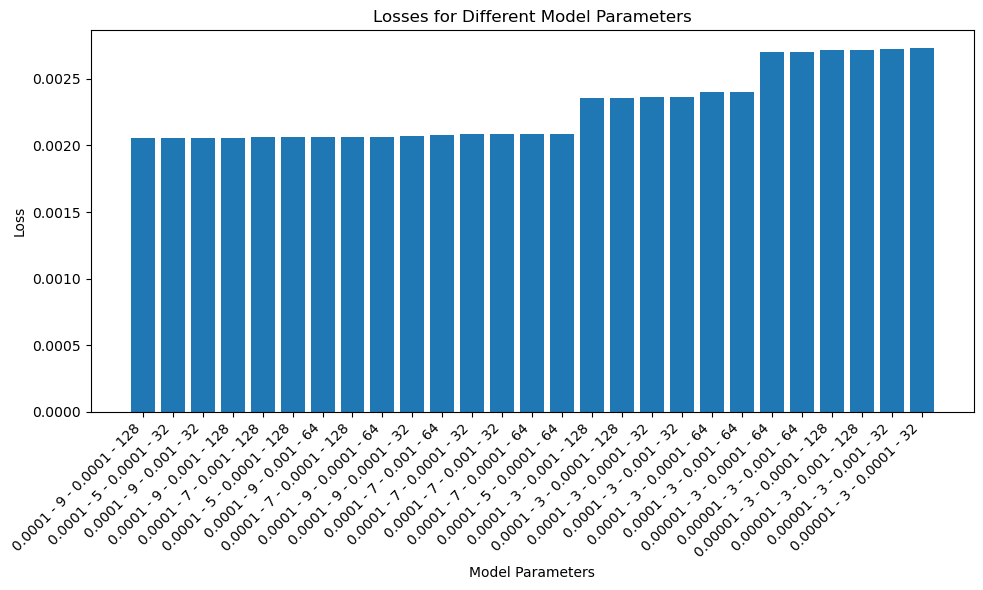

In [13]:
# plot the losses
losses_df = pd.DataFrame(losses.items(), columns=['params', 'loss'])

losses_df[['lr', 'n_layers', 'kl_min', 'latent_dim']] = pd.DataFrame(losses_df['params'].tolist(), index=losses_df.index)
losses_df = losses_df.drop(columns=['params'])
losses_df = losses_df.sort_values(by='loss')
plt.figure(figsize=(10, 6))
plt.bar(losses_df['lr'].astype(str) + ' - ' + losses_df['n_layers'].astype(str) + ' - ' + losses_df['kl_min'].astype(str) + ' - ' + losses_df['latent_dim'].astype(str), losses_df['loss'])
plt.xlabel('Model Parameters')
plt.ylabel('Loss')
plt.title('Losses for Different Model Parameters')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'losses_{ARCHITECTURE}_{FOLDER_NAME}.png')
plt.show()


In [45]:
n_layers

[3, 5, 7, 9]

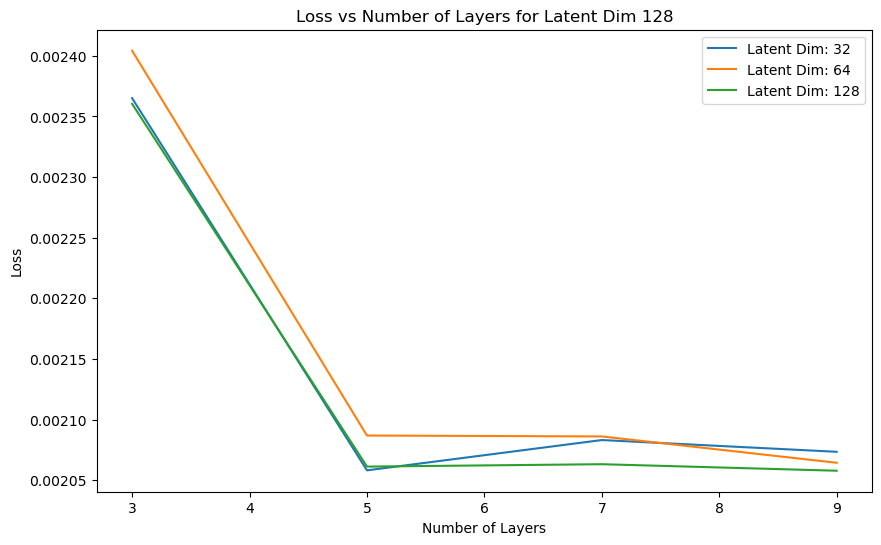

In [52]:
learn_rate = '0.0001'
kl_min = 0.0001
plt.figure(figsize=(10, 6))
for latent_dim in latent_dims:
    for n_layer in n_layers:
      layer_losses = [losses[(learn_rate, n_layer, kl_min, latent_dim)] for n_layer in n_layers if (learn_rate, n_layer, kl_min, latent_dim) in losses]
      #print( layer_losses)
    plt.plot(n_layers,layer_losses, label=f'Latent Dim: {latent_dim}')
plt.xlabel('Number of Layers')
plt.ylabel('Loss')  
plt.title(f'Loss vs Number of Layers for Latent Dim {latent_dim}')
plt.legend()
plt.show()